In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import torch
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

from fastai.distributed import *
from fastai.vision.all import *

from pathlib import Path
from functools import partial
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


import torchvision.models as models

from PIL import Image
import cv2

import json
from collections import OrderedDict

import ast

In [7]:
device = torch.device('cuda:0')
core_pth = Path('/home/agrawalp2/prepositions'); assert core_pth.exists()
spatialSenses_pth = core_pth/Path('real_world_data/spatialsense'); assert spatialSenses_pth.exists()
stupd_pth = Path('/mnt/dataset/agrawalp2/stupd_dataset'); assert stupd_pth.exists()

In [8]:
#utils
from gensim.models import KeyedVectors
import numpy as np
from autocorrect import Speller

encoder_path = spatialSenses_pth/Path('baselines/GoogleNews-vectors-negative300.bin.gz')
assert encoder_path.exists()
word2vec = KeyedVectors.load_word2vec_format(encoder_path, binary=True, unicode_errors="ignore")

spell = Speller()
def phrase2vec(phrase, max_phrase_len, word_embedding_dim):
    vec = np.zeros((max_phrase_len, word_embedding_dim,), dtype=np.float32)
    for i, word in enumerate(phrase.split()[:max_phrase_len]):
        if word in word2vec: vec[i] = word2vec[word]
        elif spell(word) in word2vec: vec[i] = word2vec[spell(word)]
        else: pass
    return vec


def read_img(url, imagepath):
    if url.startswith("http"):  # flickr
        filename = os.path.join(imagepath, "flickr", url.split("/")[-1])
    else:  # nyu
        filename = os.path.join(imagepath, "nyu", url.split("/")[-1])
    return filename
#     img = cv2.imread(filename).astype(np.float32, copy=False)[:, :, ::-1]
#     assert img.shape[2] == 3
#     return img



spatialsenses_to_stupd = {
    "above": "above",
    "behind": "behind",
    "in": "inside",
    "in front of": "in_front_of",
    "next to": "beside",
    "on": "on",
    "to the left of": "beside",
    "to the right of": "beside",
    "under": "below",
}


def map_spatialsenses_to_stupd(o, mapping_dict = spatialsenses_to_stupd):
    return spatialsenses_to_stupd[o]

def noop(x): return x

def convert_stupd_bbox_to_spatialsense_bbox(bbox):
    #stupd bbox format = wmin, hmin, w, h
    #spatialsenses bbox format = hmin, hmax, wmin, wmax
    
    wmin, hmin, w,h = bbox
    return (hmin, hmin+h, wmin, wmin+w)

In [9]:
class SpatialDataset(Dataset):
    def __init__(self, split=None, 
                 annotations_path = spatialSenses_pth/'annotations.json', 
                 image_path = spatialSenses_pth/'images',
                 x_category_tfms: list = None,
                 y_category_tfms: list = None,
                 x_img_tfms: list = None,
                bbox_mask_tfms = None):
        
        super().__init__()
        assert Path(annotations_path).exists(), f'invalid annotations file path'
        assert Path(image_path).exists(), f'invalid images directory path'
        
        self.subjects = [] #x1: subject classname
        self.objects = [] #x2: object class name
        
        self.subj_bbox = []
        self.obj_bbox = []
        
        self.predicates = [] #y: predicate (preposition) class name
        
        self.image_fnames = []
        
        
        self.split = split
        if self.split is not None: assert split in ['train', 'valid', 'test'], f"invalid selection of split. expected values = 'train', 'valid', 'test'"
        
        self.classes = list(set(spatialsenses_to_stupd.values()))
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)
        
        #transforms
        self.x_category_tfms = list(x_category_tfms or [noop]) 
        self.y_category_tfms = list(y_category_tfms or [noop]) + [lambda y: self.class2idx[y]]
        self.x_img_tfms = list(x_img_tfms or [noop]) + [transforms.ToTensor()]
        self.bbox_mask_tfms = list(bbox_mask_tfms or [noop]) + [transforms.ToTensor()]
        
        #enumerating all raw data objects
        for relations in json.load(open(annotations_path)):
            if self.split and not relations["split"] == split: continue
            for relation in relations['annotations']:
                if not relation['label']: continue
                self.subjects.append(relation['subject']['name'])
                self.objects.append(relation['object']['name'])
                self.predicates.append(relation['predicate'])
                
                self.subj_bbox.append(relation['subject']['bbox'])
                self.obj_bbox.append(relation['object']['bbox'])
                
                self.image_fnames.append(read_img(relations['url'], image_path))
                
    
    def __len__(self): return len(self.subjects)
    def __getitem__(self, i):
        #for language part of the model
        subj = self.apply_tfms(self.subjects[i], self.x_category_tfms)
        obj =  self.apply_tfms(self.objects[i] , self.x_category_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_category_tfms)
        
        #for computer vision part of the model
        img = Image.open(self.image_fnames[i])
        ih,iw = img.shape
        union_bbox = self.enlarge(self._getUnionBBox(self.subj_bbox[i], self.obj_bbox[i], ih, iw), 1.25, ih, iw)
        bbox_img = self.apply_tfms(self._getAppr(np.array(img), union_bbox), self.x_img_tfms)
        
        bbox_mask = np.stack([self._getDualMask(ih, iw,self.subj_bbox[i], 32).astype(np.uint8),
                              self._getDualMask(ih, iw, self.obj_bbox[i], 32).astype(np.uint8),
                              np.zeros((32, 32), dtype=np.uint8)],
                             2)
        bbox_mask = self.apply_tfms(bbox_mask, self.bbox_mask_tfms)[:2].float() / 255.0
    
        
        return (torch.Tensor(subj).type(torch.cuda.FloatTensor), 
                torch.Tensor(obj).type(torch.cuda.FloatTensor), 
                bbox_img.type(torch.cuda.FloatTensor),
                bbox_mask.type(torch.cuda.FloatTensor),
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o
    
    
    
    def enlarge(self, bbox, factor, ih, iw):
        height = bbox[1] - bbox[0]
        width = bbox[3] - bbox[2]
        assert height > 0 and width > 0
        return [
            max(0, int(bbox[0] - (factor - 1.0) * height / 2.0)),
            min(ih, int(bbox[1] + (factor - 1.0) * height / 2.0)),
            max(0, int(bbox[2] - (factor - 1.0) * width / 2.0)),
            min(iw, int(bbox[3] + (factor - 1.0) * width / 2.0)),
        ]

    def _getAppr(self, im, bb, out_size=224.0):
            subim = im[bb[0] : bb[1], bb[2] : bb[3], :]
            subim = cv2.resize(
                subim,
                None,
                None,
                out_size / subim.shape[1],
                out_size / subim.shape[0],
                interpolation=cv2.INTER_LINEAR,
            )
            subim = (subim / 255.0 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225] #mean and std of imagenet
            return subim.astype(np.float32, copy=False)

    def _getUnionBBox(self, aBB, bBB, ih, iw, margin=10):
            return [max(0, min(aBB[0], bBB[0]) - margin),
                    min(ih, max(aBB[1], bBB[1]) + margin),
                    max(0, min(aBB[2], bBB[2]) - margin),
                    min(iw, max(aBB[3], bBB[3]) + margin)]
        
    def _getDualMask(self, ih, iw, bb, heatmap_size=32):
            rh = float(heatmap_size) / ih
            rw = float(heatmap_size) / iw
            x1 = max(0, int(math.floor(bb[0] * rh)))
            x2 = min(heatmap_size, int(math.ceil(bb[1] * rh)))
            y1 = max(0, int(math.floor(bb[2] * rw)))
            y2 = min(heatmap_size, int(math.ceil(bb[3] * rw)))
            mask = np.zeros((heatmap_size, heatmap_size), dtype=np.float32)
            mask[x1:x2, y1:y2] = 255
            return mask

In [10]:
max_phrase_len = 2 #subjects/objects can be mutliple words. eg - microwave oven. max_phrase_len decides how many words are used to create embeddings
word_embedding_dim = 300 #decides the dimension of the feature each word is converted into

embedding = partial(phrase2vec, max_phrase_len = max_phrase_len, word_embedding_dim = word_embedding_dim)

train_ds = SpatialDataset(split = 'train',
                          x_category_tfms = [embedding],
                          y_category_tfms = [map_spatialsenses_to_stupd],
                          x_img_tfms =     [transforms.ToPILImage("RGB"),
                                            transforms.RandomResizedCrop(224, scale=(0.75, 0.85)),
                                            transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)],
            
                          bbox_mask_tfms = [transforms.ToPILImage("RGB"),
                                            transforms.Pad(4, padding_mode="edge"),
                                            transforms.RandomResizedCrop(32, scale=(0.75, 0.85))]
                         )

valid_ds = SpatialDataset(split = 'valid',
                          x_category_tfms = [embedding],
                          y_category_tfms = [map_spatialsenses_to_stupd],
                          x_img_tfms =     [transforms.ToPILImage("RGB"),
                                            transforms.CenterCrop(224)],
                          
                          bbox_mask_tfms = [transforms.ToPILImage("RGB"),
                                            transforms.Pad(4, padding_mode="edge"),
                                            transforms.CenterCrop(32)]
                         )

len(train_ds),len(valid_ds)

(5619, 1319)

In [12]:
for o in train_ds[0]: print(o.shape)

torch.Size([2, 300])
torch.Size([2, 300])
torch.Size([3, 224, 224])
torch.Size([2, 32, 32])
torch.Size([1])


In [7]:
train_dl = DataLoader(train_ds, batch_size =64 , shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 128 , shuffle = True)

In [8]:
#helper models
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, in_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1)
        self.layernorm1 = nn.LayerNorm((out_channels // 2, in_size, in_size))
        self.conv2 = nn.Conv2d(
            out_channels // 2, out_channels // 2, kernel_size=3, padding=1
        )
        self.layernorm2 = nn.LayerNorm((out_channels // 2, in_size, in_size))
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1)
        self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, inp):
        x = F.relu(self.layernorm1(self.conv1(inp)))
        x = F.relu(self.layernorm2(self.conv2(x)))
        x = self.conv3(x)
        return x + self.conv_skip(inp)

class Hourglass(nn.Module):
    def __init__(self, im_size, feature_dim):
        super().__init__()
        assert im_size == 1 or im_size % 2 == 0
        self.skip_resblock = ResidualBlock(feature_dim, feature_dim, im_size)
        if im_size > 1:
            self.pre_resblock = ResidualBlock(feature_dim, feature_dim, im_size // 2)
            self.layernorm1 = nn.LayerNorm((feature_dim, im_size // 2, im_size // 2))
            self.sub_hourglass = Hourglass(im_size // 2, feature_dim)
            self.layernorm2 = nn.LayerNorm((feature_dim, im_size // 2, im_size // 2))
            self.post_resblock = ResidualBlock(feature_dim, feature_dim, im_size // 2)

    def forward(self, x):
        up = self.skip_resblock(x)
        if x.size(-1) == 1:
            return up
        down = F.max_pool2d(x, 2)
        down = F.relu(self.layernorm1(self.pre_resblock(down)))
        down = F.relu(self.layernorm2(self.sub_hourglass(down)))
        down = self.post_resblock(down)
        down = F.upsample(down, scale_factor=2)
        return up + down

    
    
class PhraseEncoder(nn.Module):
    def __init__(self, word_embedding_dim, num_layers = 1, batch_first = True, bidirectional = True):
        super().__init__()
        self.encoder = nn.GRU(input_size = word_embedding_dim, 
                                     hidden_size = word_embedding_dim//2,
                                     num_layers = num_layers,
                                     batch_first = batch_first,
                                     bidirectional = bidirectional,
                                    )
    def forward(self, x): return torch.squeeze(self.encoder(x)[0][:,-1,:])
    
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(input_dim, output_dim)
        self.batchnorm = nn.BatchNorm1d(output_dim)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batchnorm(x)
        x = self.ReLU(x)
        return x
    

In [9]:
class DRNet(nn.Module):
    def __init__(self, phrase_encoder, feature_dim, num_classes, num_layers=3, backbone='resnet18'):
        super(DRNet, self).__init__()
        

        self.phrase_encoder =  phrase_encoder
        self.feature_dim = feature_dim
        
        self.appr_module = models.__dict__[backbone](pretrained=True)
#         self.appr_module = backbone(pretrained = True)
        self.appr_module.fc = nn.Linear(512, feature_dim//2)
        
        self.num_layers = num_layers
        self.c = num_classes

        self.pos_module = nn.Sequential(
            OrderedDict(
                [
                    ("conv1_p", nn.Conv2d(2, 32, 5, 2, 2)),
                    ("batchnorm1_p", nn.BatchNorm2d(32)),
                    ("relu1_p", nn.ReLU()),
                    ("conv2_p", nn.Conv2d(32, 64, 3, 1, 1)),
                    ("batchnorm2_p", nn.BatchNorm2d(64)),
                    ("relu2_p", nn.ReLU()),
                    ("maxpool2_p", nn.MaxPool2d(2)),
                    ("hg", Hourglass(8, 64)),
                    ("batchnorm_p", nn.BatchNorm2d(64)),
                    ("relu_p", nn.ReLU()),
                    ("maxpool_p", nn.MaxPool2d(2)),
                    ("conv3_p", nn.Conv2d(64, feature_dim//2, 4)),
                    ("batchnorm3_p", nn.BatchNorm2d(feature_dim//2)),
                ]
            )
        )

#         self.PhiR_0 = nn.Linear(512, feature_dim)
        self.batchnorm = nn.BatchNorm1d(feature_dim)

        self.Phi_subj = nn.Linear(300, feature_dim//2)
        self.Phi_obj = nn.Linear(300, feature_dim//2)
#         self.PhiR = nn.Linear(feature_dim, feature_dim)

#         self.fc = nn.Linear(feature_dim, 9)
        self.fc = nn.Sequential(LinearBlock(2*feature_dim,feature_dim), 
                                LinearBlock(feature_dim, feature_dim//2), 
                                nn.Linear(feature_dim//2, self.c))

    def forward(self, subj, obj, im, posdata):
        appr_feature = self.appr_module(im) #output 256 features
        pos_feature = (self.pos_module(posdata).view(-1, self.feature_dim//2))#output 256 features
        
        
        qa = self.phrase_encoder(subj)
        qb = self.phrase_encoder(obj)
        
        x = torch.cat([appr_feature, 
                       pos_feature,
                       self.Phi_subj(qa), self.Phi_obj(qb),
                      ], 1)

#         qr = F.relu(self.batchnorm(self.PhiR_0(torch.cat([appr_feature, pos_feature], 1))))

#         qa = self.phrase_encoder(subj)
#         qb = self.phrase_encoder(obj)
#         for i in range(self.num_layers):
#             qr = F.relu(self.PhiA(qa) + self.PhiB(qb) + self.PhiR(qr))

#         qr = self.fc(qr)
        x = self.fc(x)
        return x

In [26]:
dls = DataLoaders(train_dl, valid_dl)
dls.n_inp = 4

phrase_encoder = PhraseEncoder(300)
model = model = DRNet(phrase_encoder, 512, train_ds.c).cuda()

learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

In [27]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.689916,1.712701,0.359363,0.221295,01:05
1,1.515124,1.463387,0.452616,0.327940,01:05
2,1.396506,1.383211,0.494314,0.387329,01:05
3,1.291989,1.391297,0.498105,0.396948,01:05
4,1.223384,1.365589,0.495072,0.425831,01:05
5,1.135480,1.364263,0.520849,0.443239,01:05
6,1.062435,1.349620,0.526914,0.461275,01:05
7,0.963906,1.379919,0.518575,0.449859,01:05
8,0.880227,1.382702,0.529189,0.459105,01:05
9,0.834297,1.381590,0.527672,0.455960,01:05


# Pretraining on stupd now

In [25]:
class stupd(Dataset):
    def __init__(self, 
                 annotations_path = stupd_pth/'annotations', 
                 image_path = stupd_pth/'stupd',
                 x_category_tfms: list = None,
                 y_category_tfms: list = None,
                 x_img_tfms: list = None,
                bbox_mask_tfms = None):
        
        super().__init__()
        assert Path(annotations_path).exists(), f'invalid annotations file path'
        assert Path(image_path).exists(), f'invalid images directory path'
        
        self.subjects = [] #x1: subject classname
        self.objects = [] #x2: object class name
        
        self.subj_bbox = []
        self.obj_bbox = []
        
        self.predicates = [] #y: predicate (preposition) class name
        
        self.image_fnames = []
        
        
        
        self.classes = list(set(spatialsenses_to_stupd.values()))
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)
        
        #transforms
        self.x_category_tfms = list(x_category_tfms or [noop]) 
        self.y_category_tfms = list(y_category_tfms or [noop]) + [lambda y: self.class2idx[y]]
        self.x_img_tfms = list(x_img_tfms or [noop]) + [transforms.ToTensor()]
        self.bbox_mask_tfms = list(bbox_mask_tfms or [noop]) + [transforms.ToTensor()]
        
        #enumerating all raw data objects
        for annotations in annotations_path.iterdir():
            
            if annotations.stem not in spatialsenses_to_stupd.values(): continue
            df = pd.read_csv(annotations).dropna()
            for i,row in df.iterrows():
#                 self.subjects.append(relation['subject']['name'])
#                 self.objects.append(relation['object']['name'])
#                 self.predicates.append(relation['predicate'])
                
#                 self.subj_bbox.append(relation['subject']['bbox'])
#                 self.obj_bbox.append(relation['object']['bbox'])
                
#                 self.image_fnames.append(read_img(relations['url'], image_path))
                self.subjects.append(row['subject_category'] + ' ' + row['subject_supercategory'])
                self.objects.append(row['object_category'] + ' ' + row['object_supercategory'])
                self.predicates.append(annotations.stem)
            
                subj_2dbbox = ast.literal_eval(row['subject_bbox2d'])[0]
                obj_2dbbox = ast.literal_eval(row['object_bbox2d'])[0]

                self.subj_bbox.append(convert_stupd_bbox_to_spatialsense_bbox(subj_2dbbox))
                self.obj_bbox.append(convert_stupd_bbox_to_spatialsense_bbox(obj_2dbbox))
                
                img_pth = ast.literal_eval(row['image_path'])[0]
                self.image_fnames.append(image_path/img_pth)
                
    
    def __len__(self): return len(self.subjects)
    def __getitem__(self, i):
        #for language part of the model
        subj = self.apply_tfms(self.subjects[i], self.x_category_tfms)
        obj =  self.apply_tfms(self.objects[i] , self.x_category_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_category_tfms)
        
        #for computer vision part of the model
        img = Image.open(self.image_fnames[i])
        ih,iw = img.shape
        union_bbox = self.enlarge(self._getUnionBBox(self.subj_bbox[i], self.obj_bbox[i], ih, iw), 1.25, ih, iw)
        bbox_img = self.apply_tfms(self._getAppr(np.array(img)[:,:,:3], union_bbox), self.x_img_tfms)
        
        bbox_mask = np.stack([self._getDualMask(ih, iw,self.subj_bbox[i], 32).astype(np.uint8),
                              self._getDualMask(ih, iw, self.obj_bbox[i], 32).astype(np.uint8),
                              np.zeros((32, 32), dtype=np.uint8)],
                             2)
        bbox_mask = self.apply_tfms(bbox_mask, self.bbox_mask_tfms)[:2].float() / 255.0
    
        
        return (torch.Tensor(subj).type(torch.cuda.FloatTensor), 
                torch.Tensor(obj).type(torch.cuda.FloatTensor), 
                bbox_img.type(torch.cuda.FloatTensor),
                bbox_mask.type(torch.cuda.FloatTensor),
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o
    
    
    
    def enlarge(self, bbox, factor, ih, iw):
        height = bbox[1] - bbox[0]
        width = bbox[3] - bbox[2]
        assert height > 0 and width > 0
        return [
            max(0, int(bbox[0] - (factor - 1.0) * height / 2.0)),
            min(ih, int(bbox[1] + (factor - 1.0) * height / 2.0)),
            max(0, int(bbox[2] - (factor - 1.0) * width / 2.0)),
            min(iw, int(bbox[3] + (factor - 1.0) * width / 2.0)),
        ]

    def _getAppr(self, im, bb, out_size=224.0):
            subim = im[bb[0] : bb[1], bb[2] : bb[3], :]
            subim = cv2.resize(
                subim,
                None,
                None,
                out_size / subim.shape[1],
                out_size / subim.shape[0],
                interpolation=cv2.INTER_LINEAR,
            )
            subim = (subim / 255.0 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225] #mean and std of imagenet
            return subim.astype(np.float32, copy=False)

    def _getUnionBBox(self, aBB, bBB, ih, iw, margin=10):
            return [max(0, min(aBB[0], bBB[0]) - margin),
                    min(ih, max(aBB[1], bBB[1]) + margin),
                    max(0, min(aBB[2], bBB[2]) - margin),
                    min(iw, max(aBB[3], bBB[3]) + margin)]
        
    def _getDualMask(self, ih, iw, bb, heatmap_size=32):
            rh = float(heatmap_size) / ih
            rw = float(heatmap_size) / iw
            x1 = max(0, int(math.floor(bb[0] * rh)))
            x2 = min(heatmap_size, int(math.ceil(bb[1] * rh)))
            y1 = max(0, int(math.floor(bb[2] * rw)))
            y2 = min(heatmap_size, int(math.ceil(bb[3] * rw)))
            mask = np.zeros((heatmap_size, heatmap_size), dtype=np.float32)
            mask[x1:x2, y1:y2] = 255
            return mask

In [26]:
max_phrase_len = 3 #subjects/objects can be mutliple words. eg - microwave oven. max_phrase_len decides how many words are used to create embeddings
word_embedding_dim = 300 #decides the dimension of the feature each word is converted into

embedding = partial(phrase2vec, max_phrase_len = max_phrase_len, word_embedding_dim = word_embedding_dim)

ds = stupd(
                          x_category_tfms = [embedding],
                          y_category_tfms = None,
                          x_img_tfms =     [transforms.ToPILImage("RGB"),
                                            transforms.RandomResizedCrop(224, scale=(0.75, 0.85)),
                                            transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)],
            
                          bbox_mask_tfms = [transforms.ToPILImage("RGB"),
                                            transforms.Pad(4, padding_mode="edge"),
                                            transforms.RandomResizedCrop(32, scale=(0.75, 0.85))]
                         )

len(ds)

34313

In [27]:
train_split = 0.8
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(len(ds)*train_split), len(ds) - int(len(ds)*train_split)])
train_ds.c, valid_ds.c = ds.c,ds.c

len(train_ds), len(valid_ds)

(27450, 6863)

In [28]:
train_dl = DataLoader(train_ds, batch_size =64 , shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 128 , shuffle = False)

In [29]:
dls = DataLoaders(train_dl, valid_dl)
dls.n_inp = 4

phrase_encoder = PhraseEncoder(300)
model = model = DRNet(phrase_encoder, 512, train_ds.c).cuda()

learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

SuggestedLRs(valley=0.0008317637839354575)

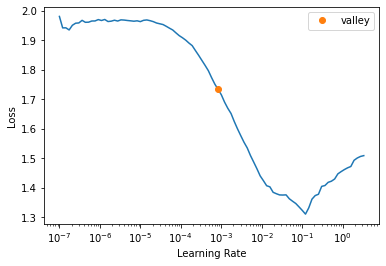

In [22]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.300086,2.000108,0.483025,0.478404,20:20
1,0.218320,1.177882,0.719365,0.721600,08:51
2,0.180899,0.332293,0.861431,0.859729,08:50
3,0.142253,0.233202,0.891155,0.891315,08:50
4,0.133482,0.137459,0.932537,0.931869,08:51


### transfering to spatialsenses

In [31]:
max_phrase_len = 2 #subjects/objects can be mutliple words. eg - microwave oven. max_phrase_len decides how many words are used to create embeddings
word_embedding_dim = 300 #decides the dimension of the feature each word is converted into

embedding = partial(phrase2vec, max_phrase_len = max_phrase_len, word_embedding_dim = word_embedding_dim)

train_ds_spatialsenses = SpatialDataset(split = 'train',
                          x_category_tfms = [embedding],
                          y_category_tfms = [map_spatialsenses_to_stupd],
                          x_img_tfms =     [transforms.ToPILImage("RGB"),
                                            transforms.RandomResizedCrop(224, scale=(0.75, 0.85)),
                                            transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)],
            
                          bbox_mask_tfms = [transforms.ToPILImage("RGB"),
                                            transforms.Pad(4, padding_mode="edge"),
                                            transforms.RandomResizedCrop(32, scale=(0.75, 0.85))]
                         )

valid_ds_spatialsenses = SpatialDataset(split = 'valid',
                          x_category_tfms = [embedding],
                          y_category_tfms = [map_spatialsenses_to_stupd],
                          x_img_tfms =     [transforms.ToPILImage("RGB"),
                                            transforms.CenterCrop(224)],
                          
                          bbox_mask_tfms = [transforms.ToPILImage("RGB"),
                                            transforms.Pad(4, padding_mode="edge"),
                                            transforms.CenterCrop(32)]
                         )

len(train_ds_spatialsenses),len(valid_ds_spatialsenses)

(5619, 1319)

In [32]:
train_dl_spatialsenses = DataLoader(train_ds_spatialsenses, batch_size =64 , shuffle = True)
valid_dl_spatialsenses = DataLoader(valid_ds_spatialsenses, batch_size = 128 , shuffle = False)

In [33]:
dls_spatialsenses = DataLoaders(train_dl_spatialsenses, valid_dl_spatialsenses)
dls_spatialsenses.n_inp = 4

In [34]:
learn = Learner(dls_spatialsenses, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

In [37]:
learn.unfreeze()

SuggestedLRs(valley=0.004365158267319202)

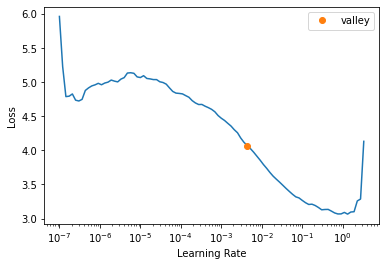

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.033285,1.481162,0.456406,0.397416,01:05
1,1.529596,1.700956,0.378317,0.308105,01:05
2,1.413788,1.554729,0.407127,0.373806,01:05
3,1.324452,1.324203,0.532221,0.451049,01:05
4,1.251819,1.426720,0.454890,0.413758,01:05
5,1.180737,1.419866,0.491281,0.431986,01:04
6,1.089032,1.324581,0.532221,0.483949,01:04
7,0.983930,1.360993,0.532980,0.469005,01:05
8,0.904676,1.365500,0.539803,0.477737,01:05
9,0.851355,1.375829,0.535254,0.480205,01:05
